In [75]:
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.visualization import *
from qiskit.quantum_info import *
import numpy as np

x1 = Parameter('x1')
x2 = Parameter('x2')
# x1x2 = Parameter('x1x2')

QC = QuantumCircuit(2, 1)

QC.h(0)
QC.h(1)
QC.rz(x1, 0)
QC.rz(x2, 1)
QC.cx(0,1)
QC.barrier()

# QC.rz(x1x2,1)

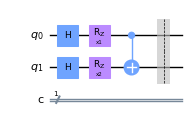

In [76]:
# QC.measure(0,0)
QC.draw(output="mpl", scale=0.5)

In [77]:
data = [np.pi/4,np.pi/4]

c = QC.bind_parameters({x1: data[0], x2: data[1]})
# c = QC.bind_parameters({x1: data[0], x2: data[1], x1x2: data[0]*data[1]})

c.draw()

┌───┐┌─────────┐      ░ 
q_0: ┤ H ├┤ Rz(π/4) ├──■───░─
     ├───┤├─────────┤┌─┴─┐ ░ 
q_1: ┤ H ├┤ Rz(π/4) ├┤ X ├─░─
     └───┘└─────────┘└───┘ ░ 
c: 1/════════════════════════

In [78]:
state = Statevector(c)
state.draw(output="Latex")

<IPython.core.display.Latex object>

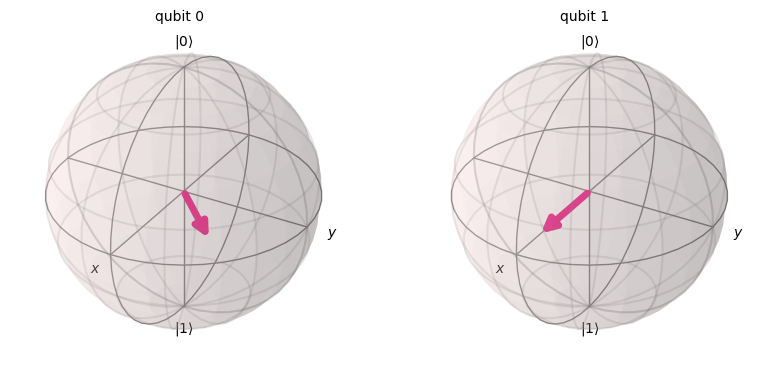

In [79]:
plot_bloch_multivector(c)

No measurements in circuit "circuit-140", classical register will remain all zeros.


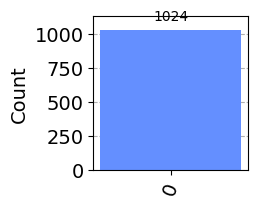

In [80]:
backend = BasicAer.get_backend('qasm_simulator')
job = backend.run(transpile(c, backend))
counts = job.result().get_counts()

plot_histogram(counts, figsize=(2,2))

In [85]:
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt

n_qubits = 2

X, y = load_iris(return_X_y=True)

# pick inputs and labels from the first two classes only,
# corresponding to the first 100 samples
X = X[:100]
y = y[:100]

# scaling the inputs is important since the embedding we use is periodic
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

for i in range(50, 100):
    print (X[i], X_scaled[i], y[i])

# scaling the labels to -1, 1 is important for the SVM and the
# definition of a hinge loss
y_scaled = 2 * (y - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)
n_qubits = len(X_train[0])
n_qubits

[7.  3.2 4.7 1.4] [2.39474331 0.21203379 1.27506221 1.09190459] 1
[6.4 3.2 4.5 1.5] [1.45501408 0.21203379 1.13639313 1.26973921] 1
[6.9 3.1 4.9 1.5] [2.23812177e+00 2.09934449e-03 1.41373130e+00 1.26973921e+00] 1
[5.5 2.3 4.  1.3] [ 0.04542025 -1.67737625  0.78972042  0.91406997] 1
[6.5 2.8 4.6 1.5] [ 1.61163562 -0.627704    1.20572767  1.26973921] 1
[5.7 2.8 4.5 1.3] [ 0.35866332 -0.627704    1.13639313  0.91406997] 1
[6.3 3.3 4.7 1.6] [1.29839254 0.42196824 1.27506221 1.44757384] 1
[4.9 2.4 3.3 1. ] [-0.89430898 -1.4674418   0.30437864  0.38056609] 1
[6.6 2.9 4.6 1.3] [ 1.76825716 -0.41776955  1.20572767  0.91406997] 1
[5.2 2.7 3.9 1.4] [-0.42444437 -0.83763845  0.72038588  1.09190459] 1
[5.  2.  3.5 1. ] [-0.73768744 -2.30717959  0.44304772  0.38056609] 1
[5.9 3.  4.2 1.5] [ 0.6719064  -0.2078351   0.92838951  1.26973921] 1
[6.  2.2 4.  1. ] [ 0.82852793 -1.88731069  0.78972042  0.38056609] 1
[6.1 2.9 4.7 1.4] [ 0.98514947 -0.41776955  1.27506221  1.09190459] 1
[5.6 2.9 3.6 1.3] [ 

4

In [89]:
dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel, interface="autograd")
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

kernel(X_train[0], X_train[0])


tensor(1., requires_grad=True)

In [90]:
a = kernel(X_train[0], X_train[0])
print(a)

1.0


In [91]:
def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)

predictions = svm.predict(X_test)
accuracy_score(predictions, y_test)

1.0